In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
import glob
import random


In [2]:
DATA_ROOT = '/kaggle/input/neural-network-stylegan-real-fake-dataset/output'
REAL_DIR = os.path.join(DATA_ROOT, 'original')
FAKE_DIR = os.path.join(DATA_ROOT, 'augmented')
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
def get_image_paths():
    real_paths =  glob.glob(os.path.join(REAL_DIR, '*.png'))
    fake_paths =  glob.glob(os.path.join(FAKE_DIR, '*.png'))
    return real_paths, fake_paths

real_paths, fake_paths = get_image_paths()
all_paths = real_paths + fake_paths
all_labels = [0]*len(real_paths) + [1]*len(fake_paths)


In [4]:
def compute_fft(image_tensor):
    grayscale = image_tensor.mean(dim=0, keepdim=True)
    fft = torch.fft.fft2(grayscale)
    fft_shifted = torch.fft.fftshift(fft)
    magnitude = torch.abs(fft_shifted)
    log_magnitude = torch.log1p(magnitude)
    log_magnitude = (log_magnitude - log_magnitude.min()) / (log_magnitude.max() - log_magnitude.min())
    return log_magnitude

class DeepfakeDataset(Dataset):
    def _init_(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
        ]) if transform is None else transform

    def _len_(self):
        return len(self.paths)

    def _getitem_(self, idx):
        image = Image.open(self.paths[idx]).convert('RGB')
        image = self.transform(image)
        fft = compute_fft(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return (image, fft), label


In [5]:
# First split: 80% train, 20% temp
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

# Split temp into validation and test (50% each)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

class DeepfakeDataset(Dataset):
    def __init__(self, paths, labels, transform=None):  # Double underscores
        self.paths = paths
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
        ]) if transform is None else transform

    def __len__(self):  # Double underscores
        return len(self.paths)

    def __getitem__(self, idx):  # Double underscores
        image = Image.open(self.paths[idx]).convert('RGB')
        image = self.transform(image)
        fft = compute_fft(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return (image, fft), label
        
# Create datasets
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_dataset = DeepfakeDataset(train_paths, train_labels, train_transform)
val_dataset = DeepfakeDataset(val_paths, val_labels)
test_dataset = DeepfakeDataset(test_paths, test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class DualStreamModel(nn.Module):
    def __init__(self):
        super(DualStreamModel, self).__init__()
        
        # Stream 1: RGB Image Processing
        self.rgb_stream = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: 3-channel RGB
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        
        # Stream 2: FFT Feature Processing
        self.fft_stream = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1-channel FFT
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        
        # Combined Classifier
        self.classifier = nn.Sequential(
            nn.Linear(64 * (IMG_SIZE//4)**2 * 2, 128),  # Adjust based on IMG_SIZE
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()  # For binary classification (real vs. fake)
        )
    
    def forward(self, rgb, fft):
        # Process RGB stream
        rgb_features = self.rgb_stream(rgb)
        
        # Process FFT stream (add channel dimension if needed)
        if fft.dim() == 3:
            fft = fft.unsqueeze(1)  # Add channel dimension
        fft_features = self.fft_stream(fft)
        
        # Concatenate features
        combined = torch.cat([rgb_features, fft_features], dim=1)
        
        # Classify
        output = self.classifier(combined)
        return output.squeeze()  # Remove extra dimension

# Define device (GPU/CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DualStreamModel().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCELoss()

# ... (keep the model definition and other initializations the same)

best_val_acc = 0
train_losses, train_accs, val_losses, val_accs = [], [], [], []  # Added train_accs

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    correct_train = 0  # Track correct training predictions
    
    # Training phase
    for (rgb, fft), labels in train_loader:
        rgb, fft, labels = rgb.to(DEVICE), fft.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(rgb, fft)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and accuracy
        epoch_loss += loss.item() * rgb.size(0)
        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
    
    # Calculate epoch metrics
    train_loss = epoch_loss / len(train_loader.dataset)
    train_acc = correct_train / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)  # Store training accuracy

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for (rgb, fft), labels in val_loader:
            rgb, fft, labels = rgb.to(DEVICE), fft.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(rgb, fft)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * rgb.size(0)
            
            preds = (outputs > 0.5).float()
            correct_val += (preds == labels).sum().item()
    
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct_val / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print all metrics
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}\n")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")


Epoch 1/20
Train Loss: 0.6925 | Train Acc: 0.5504
Val Loss: 0.6838 | Val Acc: 0.5631

Epoch 2/20
Train Loss: 0.6831 | Train Acc: 0.5634
Val Loss: 0.6759 | Val Acc: 0.5625

Epoch 3/20
Train Loss: 0.6694 | Train Acc: 0.5809
Val Loss: 0.6497 | Val Acc: 0.5805

Epoch 4/20
Train Loss: 0.6127 | Train Acc: 0.6564
Val Loss: 0.5411 | Val Acc: 0.7449

Epoch 5/20
Train Loss: 0.4954 | Train Acc: 0.7747
Val Loss: 0.4207 | Val Acc: 0.8705

Epoch 6/20
Train Loss: 0.3887 | Train Acc: 0.8379
Val Loss: 0.3321 | Val Acc: 0.8851

Epoch 7/20
Train Loss: 0.3165 | Train Acc: 0.8771
Val Loss: 0.2408 | Val Acc: 0.9257

Epoch 8/20
Train Loss: 0.2720 | Train Acc: 0.8971
Val Loss: 0.2401 | Val Acc: 0.9043

Epoch 9/20
Train Loss: 0.2383 | Train Acc: 0.9173
Val Loss: 0.1883 | Val Acc: 0.9341

Epoch 10/20
Train Loss: 0.2042 | Train Acc: 0.9322
Val Loss: 0.1744 | Val Acc: 0.9375

Epoch 11/20
Train Loss: 0.1813 | Train Acc: 0.9400
Val Loss: 0.1569 | Val Acc: 0.9454

Epoch 12/20
Train Loss: 0.1631 | Train Acc: 0.9464
V

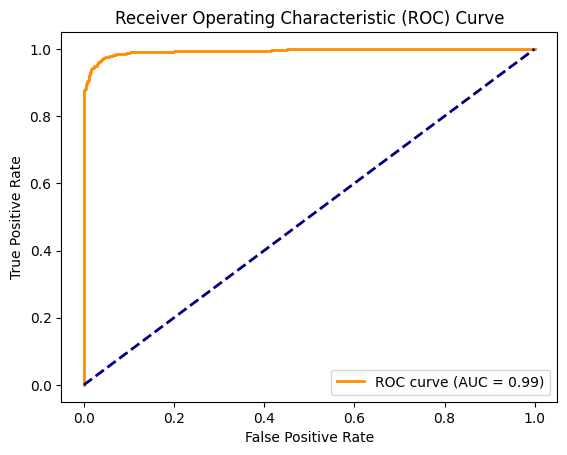

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to compute predictions and labels for the validation set
def get_predictions(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for (rgb, fft), labels in dataloader:
            rgb, fft, labels = rgb.to(device), fft.to(device), labels.to(device)
            
            outputs = model(rgb, fft)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())
    
    return all_labels, all_preds

# Get predictions and labels for the validation set
val_labels, val_preds = get_predictions(model, val_loader, DEVICE)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(val_labels, val_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

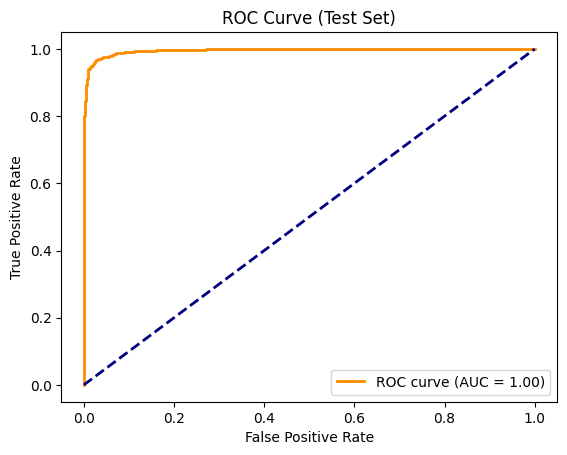

In [16]:
test_labels, test_preds = get_predictions(model, test_loader, DEVICE)

# Compute ROC curve and AUC for test set
fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, test_preds)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for test set
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc="lower right")
plt.show()

In [10]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for (rgb, fft), labels in test_loader:
        rgb, fft = rgb.to(DEVICE), fft.to(DEVICE)
        outputs = model(rgb, fft)
        test_preds.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_preds_binary = [1 if p > 0.5 else 0 for p in test_preds]


<ipython-input-10-449ebb0bb58e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


In [11]:
print("\nClassification Report:")
print(classification_report(test_labels, test_preds_binary, target_names=['Real', 'Fake']))



Classification Report:
              precision    recall  f1-score   support

        Real       0.96      0.97      0.96       777
        Fake       0.98      0.97      0.97      1000

    accuracy                           0.97      1777
   macro avg       0.97      0.97      0.97      1777
weighted avg       0.97      0.97      0.97      1777



In [12]:
torch.save(model.state_dict(), "final_deepfake_detector.pth")


In [13]:
def predict_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)
    fft = compute_fft(image_tensor.squeeze()).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model(image_tensor, fft)
    
    prob = output.item()
    pred = "Fake" if prob > 0.5 else "Real"
    return pred, prob


In [15]:
random_images = random.choices(test_paths, k=5)
for img_path in random_images:
    pred, prob = predict_image(img_path)
    print(f"Image: {os.path.basename(img_path)}")
    print(f"Prediction: {pred} ({prob:.4f})")
    print("-" * 50)

Image: orig_05095.png
Prediction: Real (0.1842)
--------------------------------------------------
Image: aug_05094.png
Prediction: Fake (1.0000)
--------------------------------------------------
Image: aug_09909.png
Prediction: Fake (1.0000)
--------------------------------------------------
Image: aug_03431.png
Prediction: Fake (1.0000)
--------------------------------------------------
Image: aug_04624.png
Prediction: Fake (0.9876)
--------------------------------------------------
